In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score as r2
import warnings 

warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

plt.figure(figsize=(18, 18))

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

In [2]:
DATA_TRAINS = 'train.csv'
DATA_TEST = 'test.csv'

In [3]:
trains = pd.read_csv(DATA_TRAINS)

In [4]:
trains.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [5]:
trains.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [6]:
tests = pd.read_csv(DATA_TEST)

In [7]:
tests.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [8]:
trains['Id'] = trains['Id'].astype(str)
trains['DistrictId'] = trains['DistrictId'].astype(str)

## 1. EDA

Делаем EDA для:

 * Исправления выбросов

 * Заполнения

 * Идей для генерации новых фич

### **Целевая переменнная**

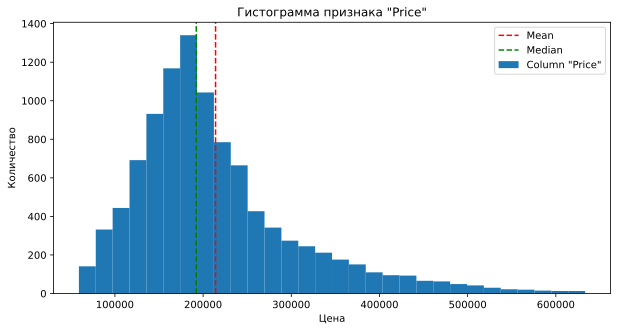

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(trains['Price'], bins=30, label='Column "Price"')
plt.axvline(trains['Price'].mean(), color='red', linestyle='dashed', label='Mean')
plt.axvline(trains['Price'].median(), color='green', linestyle='dashed', label='Median')
plt.ylabel('Количество')
plt.xlabel('Цена')
plt.title('Гистограмма признака "Price"')
plt.legend()
plt.show()

Распределение целевого впризнака **"Price"** выглядит правдоподобным

### **Количественные переменнные**

In [10]:
trains.select_dtypes(include=['float64', 'int64'])

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0,305018.871089
1,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.553407
2,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.720850
3,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.007630
4,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,52,10311,6,NaN,1,9,119367.455796
9996,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,2,629,1,NaN,0,0,199715.148807
9997,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,20,4386,14,NaN,1,5,165953.912580
9998,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,47,8004,3,125.0,3,5,171842.411855


построим гистограммы кличественных признаков

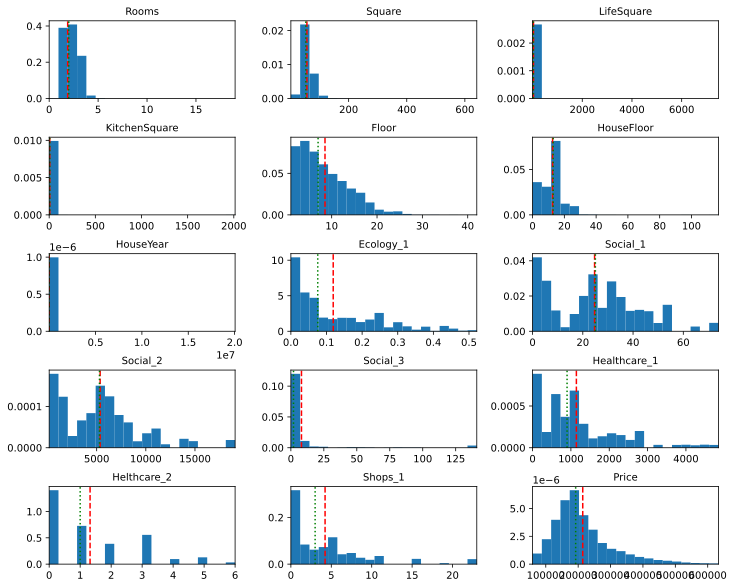

In [11]:
def build_histogramms(df, columns=None, ncols=3, column_x='Price'):
    if columns is None:
        columns = []
    
    if column_x not in columns:
        columns.append(column_x)
    df = df[columns].copy()
    
    nrows, tail = divmod(len(columns), ncols)
    if tail:
        nrows += 1

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(12, 10)
    plots = ax.flatten()
    
    title_style = {
        'fontsize': 10,
    }
    
    for idx, column in enumerate(columns):
        plots[idx].hist(df[column], bins=20, density=True)
        plots[idx].axvline(df[column].mean(), linestyle='dashed', color='red')
        plots[idx].axvline(df[column].median(), linestyle='dotted', color='green')
        plots[idx].set_title(column, title_style)
        plots[idx].set_xlim([df[column].min(), df[column].max()])
        
    plt.subplots_adjust(wspace=0.3, hspace=0.5)


build_histogramms(
    trains,
    trains.select_dtypes(include=['float64', 'int64']).columns.values.tolist()
)

In [12]:
def build_scatters(df, columns=None, ncols=3, column_x='Price'):
    if columns is None:
        columns = []
        
    if column_x not in columns:
        columns.append(column_x)
    df = df[columns].copy()
    
    nrows, tail = divmod(len(columns), ncols)
    if tail:
        nrows += 1

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(12, 14)
    plots = ax.flatten()
    
    title_style = {
        'fontsize': 10,
    }
    
    for idx, column in enumerate(columns):
        if column == column_x:
            continue
        plots[idx].scatter(df[column_x], df[column])
        plots[idx].set_title(column, title_style)
        plots[idx].set_xlabel(column_x)
        plots[idx].set_ylabel(column)
        plots[idx].set_xlim([df[column_x].min(), df[column_x].max()])
        plots[idx].set_ylim([df[column].min(), df[column].max()])
        
    plt.subplots_adjust(wspace=0.3, hspace=1)


#build_scatters(
#     trains,
#     trains.select_dtypes(include=['float64', 'int64']).columns.values.tolist(),
#)

Есть выбросы у признаков: Rooms, Square, LifeSquare, KitchenSquare, HouseFloor, HouseYear.

### **Номинативные переменные**

In [13]:
for column_name, column_values in trains.select_dtypes(include='object').iteritems():
    print()
    print("-----------------")
    print()
    print(column_name)
    print()
    print(column_values.value_counts())


-----------------

Id

4090     1
15793    1
4073     1
801      1
16359    1
        ..
14588    1
6316     1
9555     1
6350     1
6279     1
Name: Id, Length: 10000, dtype: int64

-----------------

DistrictId

27     851
1      652
23     565
6      511
9      294
      ... 
117      1
205      1
196      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

-----------------

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64

-----------------

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64

-----------------

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64


## 2. Обработка выбросов

1. Выкинуть данные

2. Заменять выбросы разными данными (медианы, средние значения и т. д.)

3. Делать или не делать дополнительную фичу

4. Ничего не делать

### **HouseYear > 2020**

In [14]:
trains.loc[trains['HouseYear'] > 2020, 'HouseYear'] = 2020

### Rooms = 0 и Rooms > 5

In [15]:
rooms_median = trains[trains['Rooms'] < 6].groupby('Rooms').agg({'Square': 'median'})
square_rooms_median_list = rooms_median.values.T[0].tolist()

def _correct_rooms(square):    
    room_square = min([(square_rooms_median_list.index(m) + 1, np.abs(m - square)) for m in square_rooms_median_list], key=lambda x: x[1])
    return room_square[1]
    
trains.loc[trains['Rooms'] == 0, 'Rooms'] = 1
trains.loc[trains['Rooms'] > 5, 'Rooms'] = trains[trains['Rooms'] > 5]['Square'].apply(_correct_rooms)

### HouseFloor = 0

In [16]:
# получим моду этажности зданий сгрупированные по HouseYear
housefloor_mode = trains.loc[trains['HouseFloor'] != 0].groupby('HouseYear').agg(
    housefloor_mode=('HouseFloor', lambda x: x.value_counts().index[0]),
)
housefloor_mean = trains['HouseFloor'].mean()

trains = pd.merge(trains, housefloor_mode, on='HouseYear', how='left')
trains.loc[(trains['HouseFloor'] == 0), 'HouseFloor'] = trains['housefloor_mode']
trains['HouseFloor'].fillna(housefloor_mean, inplace=True)
trains.drop('housefloor_mode', axis=1, inplace=True)

### Floor = 0

In [17]:
# заполним рандомно значениями из интервала от 1 до'HouseFloor'
np.random.seed(42)

trains.loc[trains['Floor'] == 0, 'Floor'] = np.random.randint(1, trains[trains['Floor'] == 0]['HouseFloor'] + 1)

### Ecology_1 = 0

In [18]:
# получим Ecology_1 сгрупированные по DistrictId
ecology_1_group_mean = trains.loc[trains['Ecology_1'] != 0].groupby('DistrictId').agg(
    ecology_1_mean=('Ecology_1', 'mean'),
)
ecology_1_mean = ecology_1_group_mean['ecology_1_mean'].mean()

trains = pd.merge(trains, ecology_1_group_mean, on='DistrictId', how='left')
trains.loc[(trains['Ecology_1'] == 0), 'Ecology_1'] = trains['ecology_1_mean']
trains['Ecology_1'].fillna(ecology_1_mean, inplace=True)
trains.drop('ecology_1_mean', axis=1, inplace=True)

### Healthcare_1 отсутствующие значения

In [19]:
healthcare_1_mean = trains[~trains['Healthcare_1'].isna()].\
                     groupby('DistrictId').agg(healthcare_1_mean=('Healthcare_1', 'mean'))

trains = pd.merge(trains, healthcare_1_mean, on='DistrictId', how='left')
trains['Healthcare_1'].fillna(trains['healthcare_1_mean'], inplace=True)
trains['Healthcare_1'].fillna(trains['healthcare_1_mean'].mean(), inplace=True)
trains.drop('healthcare_1_mean', axis=1, inplace=True)

### LifeSquare отсутствующие значения

In [20]:
lifesquare_mean = trains.loc[~trains['LifeSquare'].isna()].groupby(['HouseYear', 'Rooms']).agg(
    mean_s=('Square', 'mean'),
    mean_ls=('LifeSquare', 'mean'),
)
        
trains = pd.merge(trains, lifesquare_mean, on=['HouseYear', 'Rooms'], how='left')
trains['LifeSquare'].fillna(trains['Square'] * (trains['mean_ls'] / trains['mean_s']), inplace=True)
trains.loc[trains['LifeSquare'].isna(), 'LifeSquare'] = trains['Square'] - (trains['KitchenSquare'] + 4)
trains.drop(['mean_ls', 'mean_s'], axis=1, inplace=True)

### Перепутаны местами значения признаков:

In [21]:
trains.loc[trains['LifeSquare'] > trains['Square'], ['LifeSquare', 'Square']] = trains.loc[trains['LifeSquare'] > trains['Square'], ['Square', 'LifeSquare']].values
trains.loc[trains['KitchenSquare'] > trains['LifeSquare'], ['KitchenSquare', 'LifeSquare']] = trains.loc[trains['KitchenSquare'] > trains['LifeSquare'], ['LifeSquare', 'KitchenSquare']].values
trains.loc[trains['Floor'] > trains['HouseFloor'], ['Floor', 'HouseFloor']] = trains.loc[trains['Floor'] > trains['HouseFloor'], ['HouseFloor', 'Floor']].values

### KitchenSquare < 3

In [22]:
kitchensquare_mean = trains.loc[trains['KitchenSquare'] > 1].groupby(['HouseYear', 'Rooms']).agg(
     mean_s=('Square', 'mean'),
     mean_ks=('KitchenSquare', 'mean'),
)

trains = pd.merge(trains, kitchensquare_mean, on=['HouseYear', 'Rooms'], how='left')
trains.loc[(trains['KitchenSquare'] <= 1), 'KitchenSquare'] = trains['Square'] * (trains['mean_ks'] / trains['mean_s'])
trains.drop(['mean_s', 'mean_ks'], axis=1, inplace=True)
trains['KitchenSquare'].fillna((trains['Square'] / trains['Rooms']) / 2, inplace=True)
trains.loc[trains['KitchenSquare'] < 3, 'KitchenSquare'] =  3

### Square, KitchenSquare, LifeSquare  имеют выбросы

In [23]:
square_q_min = trains['Square'].quantile(0.0025)
square_q_max = trains['Square'].quantile(0.9975)

kitchensquare_q_min = trains['KitchenSquare'].quantile(0.0025)
kitchensquare_q_max = trains['KitchenSquare'].quantile(0.9975)

lifesquare_q_min = trains['LifeSquare'].quantile(0.0025)
lifesquare_q_max = trains['LifeSquare'].quantile(0.9975)

 # Square, KitchenSquare, LifeSquare имеют выбросы
trains.loc[(trains['Square'] < square_q_min) | (trains['Square'] > square_q_max), 'Square'] = trains['Square'].median()
        
trains.loc[trains['KitchenSquare'] > kitchensquare_q_max, 'KitchenSquare'] = trains['KitchenSquare'].median()
        
trains.loc[(trains['LifeSquare'] < lifesquare_q_min) | (trains['LifeSquare'] > lifesquare_q_max), 'LifeSquare'] = trains['LifeSquare'].median()
        

### Корреляционная матрица

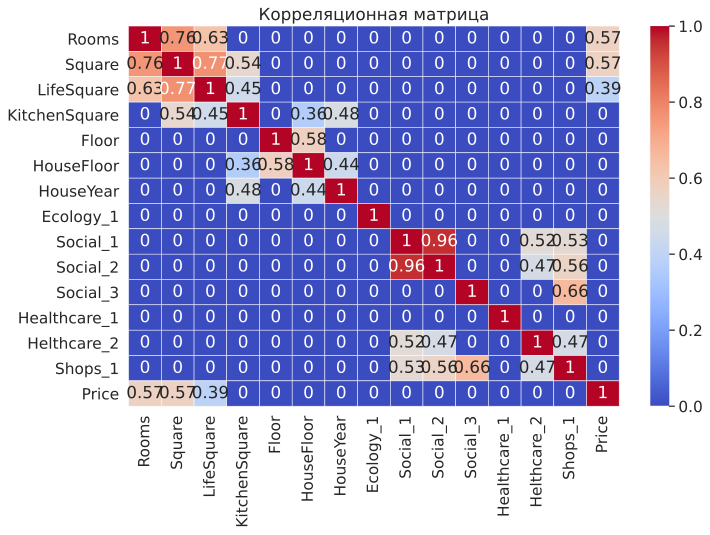

In [24]:
plt.figure(figsize=(11, 7))
sns.set(font_scale=1.4)
corr_matrix = trains.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

In [25]:
class DataPreprocessing:
    """ Подготовка исходных данных """
    
    def __init__(self):
        """ Инициализация """
        self.mode_housefloor = None
        self.median_housefloor = None
        self.square_rooms_median_list = []
        self.healthcare_1_mean = None
        self.lifesquare_mean = None
        self.kitchensquare_mean = None
        # квантили признака Square, KitchenSquare, LifeSquare q=0,025 и q=99,975
        self.square_q_min = None
        self.square_q_max = None
        
        self.kitchensquare_q_min = None
        self.kitchensquare_q_max = None
        
        self.lifesquare_q_min = None
        self.lifesquare_q_max = None
        
        self.ecology_1_group_mean = None
        self.ecology_1_mean = None
    
        self.medians = None
    
    def _correct_rooms(self, square):    
        room_square = min([(self.square_rooms_median_list.index(m) + 1, np.abs(m - square)) for m in self.square_rooms_median_list], key=lambda x: x[1])
        return room_square[1]

    def fit(self, X):
        """ Сохранение статистик """
        # получим моду этажности зданий сгрупированные по HouseYear
        self.housefloor_mode = X.loc[X['HouseFloor'] != 0].groupby('HouseYear').agg(
            housefloor_mode=('HouseFloor', lambda x: x.value_counts().index[0]),
        )
        self.housefloor_mean = X['HouseFloor'].mean()
        
        # получим список средних значений Square квартир скрупированных по Rooms
        rooms_median = X[X['Rooms'] < 6].groupby('Rooms').agg({'Square': 'median'})
        self.square_rooms_median_list = rooms_median.values.T[0].tolist()
        
        # получим средние значения непустых значений признака "Healthcare_1" сгрупированых по "DistrictId"
        self.healthcare_1_mean = X[~X['Healthcare_1'].isna()].\
                    groupby('DistrictId').agg(healthcare_1_mean=('Healthcare_1', 'mean'))
        
        # сгруппирукем данные по полям 'HouseYear' и 'Rooms', чтоб получить средние значения 'Square' и 'LifeSquare'
        self.lifesquare_mean = X.loc[~X['LifeSquare'].isna()].groupby(['HouseYear', 'Rooms']).agg(
            mean_s=('Square', 'mean'),
            mean_ls=('LifeSquare', 'mean'),
        )
        
        # сгруппирукем данные по полям 'HouseYear' и 'Rooms', чтоб получить средние значения 'Square' и 'KitchenSquare'
        self.kitchensquare_mean = X.loc[X['KitchenSquare'] > 1].groupby(['HouseYear', 'Rooms']).agg(
             mean_s=('Square', 'mean'),
             mean_ks=('KitchenSquare', 'mean'),
        )
        
        condition_lifesquare_calc = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        self.lifesquare_calc = X.loc[condition_lifesquare_calc, 'Square'] - (X.loc[condition_lifesquare_calc, 'KitchenSquare'] + 3)
        # квантили признака Square q=0,025 и q=99,975
        self.square_q_min = X['Square'].quantile(0.0025)
        self.square_q_max = X['Square'].quantile(0.9975)
        
        self.kitchensquare_q_min = X['KitchenSquare'].quantile(0.0025)
        self.kitchensquare_q_max = X['KitchenSquare'].quantile(0.9975)
        
        self.lifesquare_q_min = X['LifeSquare'].quantile(0.0025)
        self.lifesquare_q_max = X['LifeSquare'].quantile(0.9975)
        
        self.lifesquare_median = X['LifeSquare'].median()
        
        self.ecology_1_group_mean = X.loc[trains['Ecology_1'] != 0].groupby('DistrictId').agg(
            ecology_1_mean=('Ecology_1', 'mean'),
        )
        self.ecology_1_mean = self.ecology_1_group_mean['ecology_1_mean'].mean()
        
        self.medians = X.median()
    
    def transform(self, X):
        """ Трансформация данных """
        X = X.copy()
        
        # HouseYear > 2020
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        # Rooms = 0 и Rooms > 5
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 5, 'Rooms'] = X[X['Rooms'] > 5]['Square'].apply(self._correct_rooms)
        
        # HouseFloor = 0
        X = pd.merge(X, self.housefloor_mode, on='HouseYear', how='left')
        X.loc[(X['HouseFloor'] == 0), 'HouseFloor'] = X['housefloor_mode']
        X['HouseFloor'].fillna(self.housefloor_mean, inplace=True)
        X.drop('housefloor_mode', axis=1, inplace=True)
        
        # Floor = 0
        X.loc[X['Floor'] == 0, 'Floor'] = np.random.randint(1, X[X['Floor'] == 0]['HouseFloor'] + 1)
        
        # Healthcare_1 отсутствующие значения
        X = pd.merge(X, self.healthcare_1_mean, on='DistrictId', how='left')
        X['Healthcare_1'].fillna(X['healthcare_1_mean'], inplace=True)
        X['Healthcare_1'].fillna(X['healthcare_1_mean'].mean(), inplace=True)
        X.drop('healthcare_1_mean', axis=1, inplace=True)
        
        # LifeSquare отсутствующие значения
        X = pd.merge(X, self.lifesquare_mean, on=['HouseYear', 'Rooms'], how='left')
        X['LifeSquare'].fillna(X['Square'] * (X['mean_ls'] / X['mean_s']), inplace=True)
        X.loc[X['LifeSquare'].isna(), 'LifeSquare'] = X['Square'] - (X['KitchenSquare'] + 4)
        X.drop(['mean_ls', 'mean_s'], axis=1, inplace=True)
        
        # X['LifeSquare'].fillna(self.lifesquare_calc, inplace=True)
        # X['LifeSquare'].fillna(self.lifesquare_median, inplace=True)
        
        # Перепутаны местами значения признаков:
        X.loc[X['LifeSquare'] > X['Square'], ['LifeSquare', 'Square']] = X.loc[X['LifeSquare'] > X['Square'], ['Square', 'LifeSquare']].values
        X.loc[X['KitchenSquare'] > X['LifeSquare'], ['KitchenSquare', 'LifeSquare']] = X.loc[X['KitchenSquare'] > X['LifeSquare'], ['LifeSquare', 'KitchenSquare']].values
        X.loc[X['Floor'] > X['HouseFloor'], ['Floor', 'HouseFloor']] = X.loc[X['Floor'] > X['HouseFloor'], ['HouseFloor', 'Floor']].values
        
        # KitchenSquare < 3
        X = pd.merge(X, self.kitchensquare_mean, on=['HouseYear', 'Rooms'], how='left')
        X.loc[(X['KitchenSquare'] <= 1), 'KitchenSquare'] = X['Square'] * (X['mean_ks'] / X['mean_s'])
        X.drop(['mean_s', 'mean_ks'], axis=1, inplace=True)
        X['KitchenSquare'].fillna((X['Square'] / X['Rooms']) / 2, inplace=True)
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] =  3
        
        # Ecology_1 = 0
        X = pd.merge(X, self.ecology_1_group_mean, on='DistrictId', how='left')
        X.loc[(X['Ecology_1'] == 0), 'Ecology_1'] = X['ecology_1_mean']
        X['Ecology_1'].fillna(self.ecology_1_mean, inplace=True)
        X.drop('ecology_1_mean', axis=1, inplace=True)
        
        # Square, KitchenSquare, LifeSquare имеют выбросы
        X.loc[(X['Square'] < self.square_q_min) | (X['Square'] > self.square_q_max), 'Square'] =  self.medians['Square']
        
        X.loc[X['KitchenSquare'] > self.kitchensquare_q_max, 'KitchenSquare'] =  self.medians['KitchenSquare']
        
        X.loc[(X['LifeSquare'] < self.lifesquare_q_min) | (X['LifeSquare'] > self.lifesquare_q_max), 'LifeSquare'] =  self.medians['LifeSquare']
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [26]:
class FeatureGenerator:
    """ Генератор признаков """
    
    def __init__(self):
        """ Инициализация """
        self.column_floor_range = 'FloorRange'
        self.column_year_range = 'YearRange'
        self.column_price_district_rooms = 'PriceDistirictRooms'
        self.column_price_district_meter = 'PriceDistrictMeter'
        self.column_first_last_floor = 'FirstLastFloor'
        
        self.categorial_replace = {}
        self.price_district_rooms_median = None
        self.price_district_meter = None
        self.price_median_by_district = None
        
        self.year_ranges = (
            (0, 1970), # old
            (1970, 2002), # middle
            (2002, 2021), # new
        )
        
        self.floor_ranges = (
            (0, 3),
            (3, 5),
            (5, 9),
            (9, 14),
            (14, 150),
        )
        
    def _add_first_last_floor(self, X):
        X[self.column_first_last_floor] = 0
        X.loc[X['Floor'] == 1, self.column_first_last_floor] = 1
        X.loc[(X['Floor'] > 1) & (X['Floor'] < X['HouseFloor']), self.column_first_last_floor] = 2
        X.loc[X['Floor'] == X['HouseFloor'], self.column_first_last_floor] = 3
        return X
        
    def _delete_housefloor(self, X):
        return X.drop('HouseFloor', axis=1)
    
    def _add_price_district_rooms(self, X):
        # создадим признак средняя стоимость по квадратного метра по каждом району PriceSquareMeterDistirict
        X = pd.merge(X, self.price_median_by_district, on=['DistrictId', 'Rooms'], how='left')
        X[self.column_price_district_rooms].fillna(self.price_district_rooms_median, inplace=True)
        return X
    
    def _add_price_distirct_meter(self, X):
        X = pd.merge(X, self.price_district_meter, on=['DistrictId', 'Rooms', self.column_floor_range, self.column_year_range], how='left')
        X[self.column_price_district_meter].fillna(self.price_district_rooms_median, inplace=True)
        return X
            
    def _add_floor_range(self, X):
        X[self.column_floor_range] = 0
        for idx, floor_range in enumerate(self.floor_ranges, 1):
            X.loc[(X['Floor'] > floor_range[0]) & (X['Floor'] <= floor_range[1]), self.column_floor_range] = idx
        return X

    def _add_year_range(self, X):
        X[self.column_year_range] = 0
        for idx, year_range in enumerate(self.year_ranges, 1):
            X.loc[(X['HouseYear'] > year_range[0]) & (X['HouseYear'] <= year_range[1]), self.column_year_range] = idx
        return X
    
    def _delete_healthcare_1(self, X):    
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        return X
            
    def fit(self, X, y=None):
        """ Сохранение статистик """
        X = X.copy()
        
        self.categorial_replace = {
            'Shops_2': {'A': 0, 'B': 1},
            'Ecology_3': {'A': 0, 'B': 1},
            'Ecology_2': {'A': 0, 'B': 1},
        }
        
        # add floor_range and add_year_range
        X = self._add_floor_range(X)
        X = self._add_year_range(X)
        
        if y is not None:
            X['Price'] = y.values
            self.price_median_by_district = X.groupby(['DistrictId', 'Rooms'], as_index=False).\
                                      agg(price_median_by_district=('Price', 'median')).\
                                      rename(columns={'price_median_by_district': self.column_price_district_rooms})
            self.price_district_rooms_median = self.price_median_by_district[self.column_price_district_rooms].median()
            
            
            self.price_district_meter = X.groupby(['DistrictId', 'Rooms', self.column_floor_range, self.column_year_range], as_index=False).\
                                      agg(
                                          district_price_sum=('Price', 'sum'),
                                          district_square_sum=('Square', 'sum'),
                                      )
            self.price_district_meter[self.column_price_district_meter] = self.price_district_meter['district_price_sum'] / self.price_district_meter['district_square_sum']
            self.price_district_meter.drop(['district_price_sum', 'district_square_sum'], axis=1, inplace=True)            
            self.price_district_rooms_median = self.price_district_meter[self.column_price_district_meter].median()

    def transform(self, X):
        """ Трансформация данных """
        X = X.copy()
        
        # переведем категриальные признаки в числовой 
        X.replace(self.categorial_replace, inplace=True)
    
        # add floor_range and add_year_range
        X = self._add_floor_range(X)
        X = self._add_year_range(X)
        if self.price_district_meter is not None:
            X = self._add_price_distirct_meter(X)
        if self.price_median_by_district is not None:
            X = self._add_price_district_rooms(X)        
        X = self._add_first_last_floor(X)
        # delete 
        # X = self._delete_housefloor(X)
        # X = self._delete_healthcare_1(X)
        return X


### Отбор признаков

In [27]:
feature_names = [
    'Rooms',
    'Square',
    'LifeSquare',
     'KitchenSquare',
     'Floor',
     'HouseFloor',
     # 'HouseYear',
    'Ecology_1',
    'Ecology_2',
    'Ecology_3',
    'Social_1',
    'Social_2',
    'Social_3',
    'Helthcare_2',
    'Shops_1',
    'Shops_2'
]

new_feature_names = [
    #'FloorRange',
    # 'YearRange',
    # 'PriceDistrictMeter',
    # 'PriceDistirictRooms',
    'FirstLastFloor',
]


target_name = 'Price'

### Разбиение на train и test

In [28]:
trains = pd.read_csv(DATA_TRAINS)
trains.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [29]:
tests = pd.read_csv(DATA_TEST)
tests.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [30]:
# Создадим обучающий и целевой датасет
X = trains.drop(target_name, axis=1)
y = trains[target_name]

In [31]:
# Разобьем датасет на тренировочный и проверочный
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_valid.shape, tests.shape

((6700, 19), (3300, 19), (5000, 19))

In [32]:
# Исправление датасета

dp = DataPreprocessing()
dp.fit(X_train)

X_train = dp.transform(X_train)
X_valid = dp.transform(X_valid)
tests = dp.transform(tests)
X_train.shape, X_valid.shape, tests.shape

((6700, 19), (3300, 19), (5000, 19))

In [33]:
# Добавлния признаков в датасет

fg = FeatureGenerator()
fg.fit(X_train, y_train)

X_train = fg.transform(X_train)
X_valid = fg.transform(X_valid)
tests = fg.transform(tests)

In [34]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
tests = tests[feature_names + new_feature_names]

### Построение модели

In [35]:
def random_forest_cv():
    
    rfr_random_grid = {
         'bootstrap': [True, False],
         'max_depth': [5, 10, 15, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 7],
         'n_estimators': [400, 500]
    }
    
    rfr =  RandomForestRegressor(criterion='mse')
    
    rf_random = RandomizedSearchCV(
        estimator=rfr,
        param_distributions=rfr_random_grid,
        n_iter=15,
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs = -1,
    )
    
    rf_random.fit(X_train, y_train)
    
    y_pred_rf = rf_random.predict(X_train)
    y_pred_rf_valid = rf_random.predict(X_valid)
    
    r2_score = r2(y_train, y_pred_rf)
    r2_score_valid = r2(y_valid, y_pred_rf_valid)
    
    print(f'RandomForestRegressor train r2: {r2_score}')
    print(f'RandomForestRegressor valid r2: {r2_score_valid}')
    
    return rf_random

In [36]:
def grandient_boosting_cv():
    
    gbr_random_grid = {
        'max_depth': [15, 20, 25],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 7],
        'n_estimators': [400, 500]
    }
    
    gbr = GradientBoostingRegressor(criterion='mse')
    
    gbr_random = RandomizedSearchCV(
        estimator=gbr, 
        param_distributions=gbr_random_grid, 
        n_iter=5, 
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs = -1,
    )
    
    gbr_random.fit(X_train, y_train.values.ravel())
    
    y_pred_gbr = gbr_random.predict(X_train)
    y_pred_gbr_valid = gbr_random.predict(X_valid)
    
    r2_score = r2(y_train, y_pred_gbr)
    r2_score_valid = r2(y_valid, y_pred_gbr_valid)
    
    print(f'GradientBoostingRegressor train r2: {r2_score}')
    print(f'GradientBoostingRegressor valid r2: {r2_score_valid}')
    
    return gbr_random

In [37]:
model = grandient_boosting_cv()

Fitting 3 folds for each of 5 candidates, totalling 15 fits
GradientBoostingRegressor train r2: 0.9999999998782793
GradientBoostingRegressor valid r2: 0.6955532109824607


### Прогнозирование на тестовом датасете

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [38]:
tests_predict = model.predict(tests)

submit = pd.read_csv('sample_submission.csv')
submit['Price'] = tests_predict
submit.head()

submit.to_csv('price_prediction.csv', index=False)

In [39]:
tests_predict = model.predict(tests)

In [40]:
submit['Price'] = tests_predict

In [41]:
submit

,Id,Price
0,4567,157932.759973
1,5925,129687.398673
2,960,135085.094686
3,3848,170917.677919
4,746,186948.375860
...,...,...
4995,10379,193172.597262
4996,16138,390002.208914
4997,3912,149715.750226
4998,5722,191165.991464


In [42]:
submit.to_csv('price_prediction.csv', index=False)